In [1]:
# Add Heatwave Root to PYTHONPATH
import sys; sys.path.append('../..')

from heatwave import ERA, Country, utils

import netCDF4

import numpy as np
import pandas as pd

from scipy.interpolate import griddata
from scipy.ndimage import binary_closing

from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

import calendar
import os

In [2]:
DATA_ROOT = os.path.abspath("/Volumes/Samsung_T5/Thesis")
ERA5_ROOT = os.path.join(DATA_ROOT, 'ERA5')
T2M_PATH = os.path.join(ERA5_ROOT, 't2mmax_US_1979-2018_1jan_31dec_daily_0.25deg.nc')
SST_PATH = os.path.join(ERA5_ROOT, 'sst_1979-2018_1jan_31dec_daily_2.5deg.nc')
LSM_PATH = os.path.join(ERA5_ROOT, 'landseamask_0.75deg.nc')
CLS_PATH = os.path.join(ERA5_ROOT, 'cluster_US.nc')

In [210]:
EXTEND_SUMMER = 0
SUMMER_LEN = 60 + EXTEND_SUMMER * 2

def summer_indices(df: pd.DataFrame, extend: int=0):
    summer = []
    for year in np.unique(df.index.year):
        leap = -1 if calendar.isleap(year) else 0
        summer.append(df.loc[f"{24+leap-extend}-06-{year}":f"{22+leap+extend}-08-{year}"])
    return pd.concat(summer).values.ravel()

In [187]:
# Load Temperature at 2 Metres (T2M) data from disk
# Only load hottest 60 summer days of each year, as defined in summer_indices()
ERA5_KWARGS = {'time_origin': '1979-01-01', 'time_unit': 'D'}
T2M = ERA(T2M_PATH, 't2m', **ERA5_KWARGS)
T2M = ERA(T2M_PATH, 't2m', **ERA5_KWARGS, index=[summer_indices(T2M.time, EXTEND_SUMMER)])

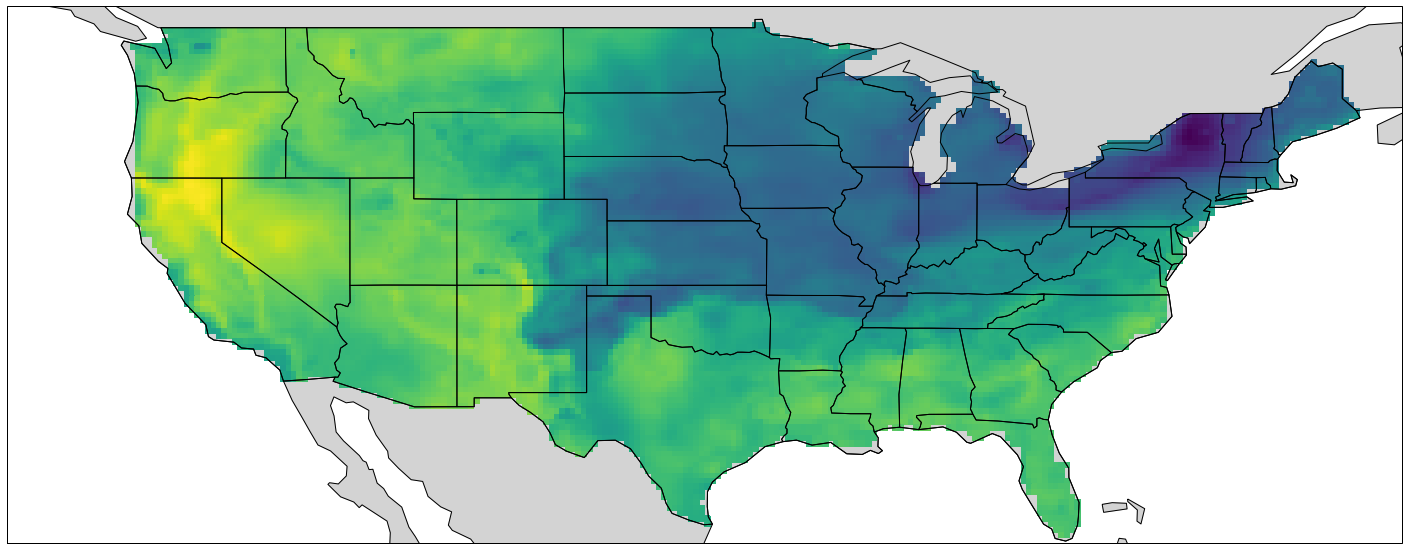

In [5]:
# Mask US (Data is already bounded for US Mainland)
# This calculation can take a while the first time, but will be buffered..
MASK_US = binary_closing(utils.era_country_mask(T2M_PATH) == Country.US)

# Calculate Land-Sea Mask
LSM = ERA(LSM_PATH, 'lsm').data
LSM_GRID = utils.era_coordinate_grid(LSM_PATH).reshape(-1, 2)
T2M_GRID = utils.era_coordinate_grid(T2M_PATH).reshape(-1, 2) + np.array([360, 0])
LSM = griddata(LSM_GRID, LSM.ravel(), T2M_GRID, 'linear').reshape(T2M.shape[1:]) > 0.5

MASK_US *= LSM

tmp = T2M.data[0].copy()
tmp[~MASK_US] = np.nan

utils.plot_earth("US")
plt.pcolormesh(T2M.longitude, T2M.latitude, tmp)
plt.show()

del LSM, LSM_GRID, T2M_GRID, tmp

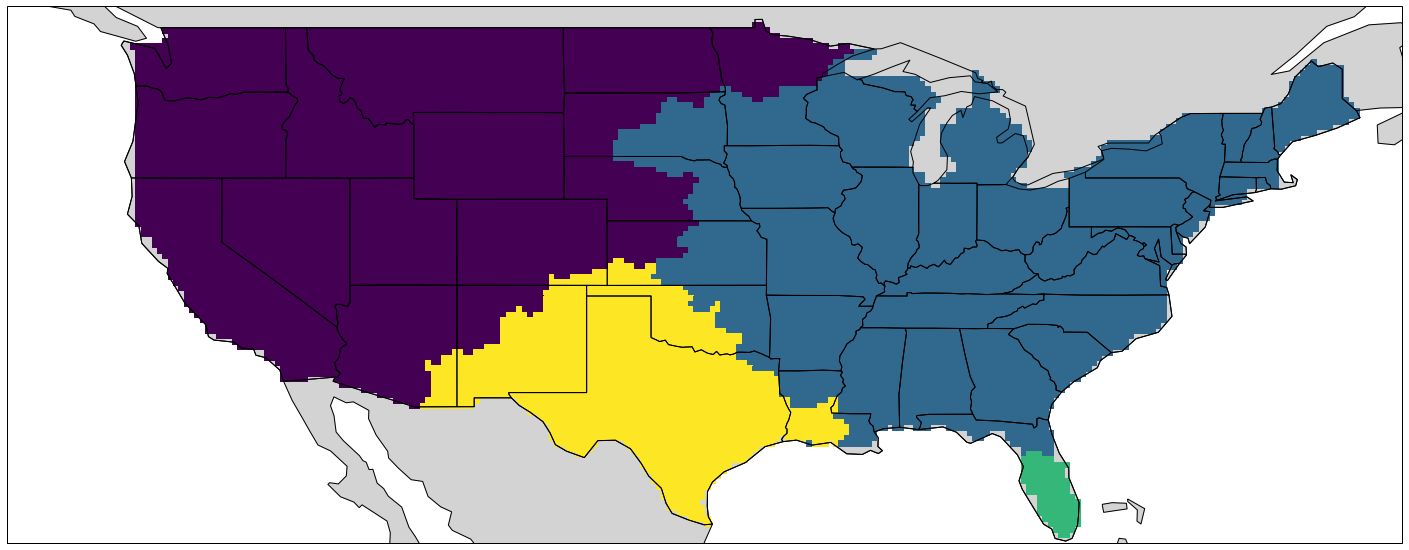

In [6]:
N = 4  # Number of Clusters

T2M_US = T2M.data[:, MASK_US]
T95_BOOL = T2M_US > np.quantile(T2M_US, 0.95, 0)

# Create Clustering to find Eastern United States
cluster = AgglomerativeClustering(N, affinity='jaccard', linkage='average')
cluster.fit(T95_BOOL.T)

# Create 2D Label Array
labels = np.empty(T2M.data.shape[1:])
labels.fill(np.nan)
labels[MASK_US] = cluster.labels_

# Find East Cluster (by looking at the maximum longitude value of each cluster and taking the max of that)
east_index = np.argmax([np.max(np.argwhere(labels==label)[:, 1]) for label in np.unique(labels[~np.isnan(labels)])])
east_mask = labels == east_index

# Plot Clusters
projection = utils.plot_earth("US")
plt.pcolormesh(T2M.longitude, T2M.latitude, labels)
plt.show()

In [7]:
KFOLDS = 4

# Get Unique Years
YEARS = np.unique(T2M.time.index.year)

# Make 'KFOLDS' groups of years, each group will be a test set
TEST_YEARS = [years.tolist() for years in np.split(YEARS, KFOLDS)]

INDICES = []

for test_years in TEST_YEARS:
    
    INDICES.append([[], []])
    
    for year in YEARS:
        indices = T2M.time[str(year)].values.ravel()
        
        if year in test_years:
            INDICES[-1][1].append(indices)
        else:
            INDICES[-1][0].append(indices)
            
    INDICES[-1][0] = np.concatenate(INDICES[-1][0])
    INDICES[-1][1] = np.concatenate(INDICES[-1][1])

In [13]:
T95 = []

# Define T95 for each fold
for train_indices, test_indices in INDICES:
    # Load Train and Test Temperature at 2 Metres (T2M) Data
    T2M_US_EAST_TRAIN = T2M.data[train_indices][:, east_mask].reshape(len(train_indices)//SUMMER_LEN, SUMMER_LEN, -1)
    T2M_US_EAST_TEST = T2M.data[test_indices][:, east_mask].reshape(len(test_indices)//SUMMER_LEN, SUMMER_LEN, -1)
    
    # Calculate daily mean and standard deviation on train set
    T2M_US_EAST_TRAIN_MEAN = T2M_US_EAST_TRAIN.mean(0, keepdims=True)
    T2M_US_EAST_TRAIN_STD = T2M_US_EAST_TRAIN.std(0, keepdims=True)
    
    # Calculate Anomalies based on train mean and standard deviation
    T2M_US_EAST_ANOMALY_TRAIN = (T2M_US_EAST_TRAIN - T2M_US_EAST_TRAIN_MEAN) / T2M_US_EAST_TRAIN_STD
    T2M_US_EAST_ANOMALY_TEST = (T2M_US_EAST_TEST - T2M_US_EAST_TRAIN_MEAN) / T2M_US_EAST_TRAIN_STD
    
    T95_TRAIN = np.quantile(T2M_US_EAST_ANOMALY_TRAIN, 0.95, -1).ravel()
    T95_TEST = np.quantile(T2M_US_EAST_ANOMALY_TEST, 0.95, -1).ravel()
    
    T95.append((
        pd.DataFrame(T95_TRAIN, index=T2M.time.index[train_indices]),
        pd.DataFrame(T95_TEST, index=T2M.time.index[test_indices])
    ))

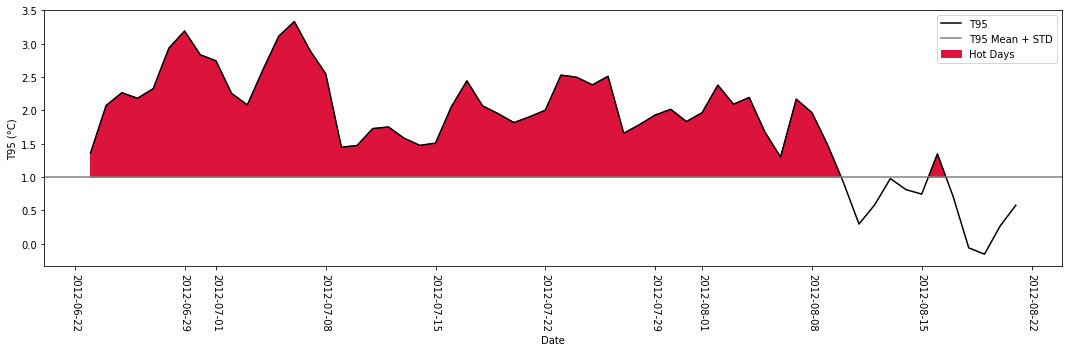

In [87]:
PLOT_YEAR = 2012
PLOT_T95 = T95[0][0][str(PLOT_YEAR)]

plt.plot(PLOT_T95, c="black", label="T95")
plt.axhline(1, c="gray", label="T95 Mean + STD")
plt.fill_between(PLOT_T95.index, [1]*len(PLOT_T95), PLOT_T95.values.ravel(),
                where=PLOT_T95.values.ravel() > 1, interpolate=True, color='crimson',
                label="Hot Days")
plt.ylabel("T95 (°C)")
plt.xlabel("Date")
plt.xticks(rotation=-90)
plt.legend()
plt.tight_layout()
plt.show()

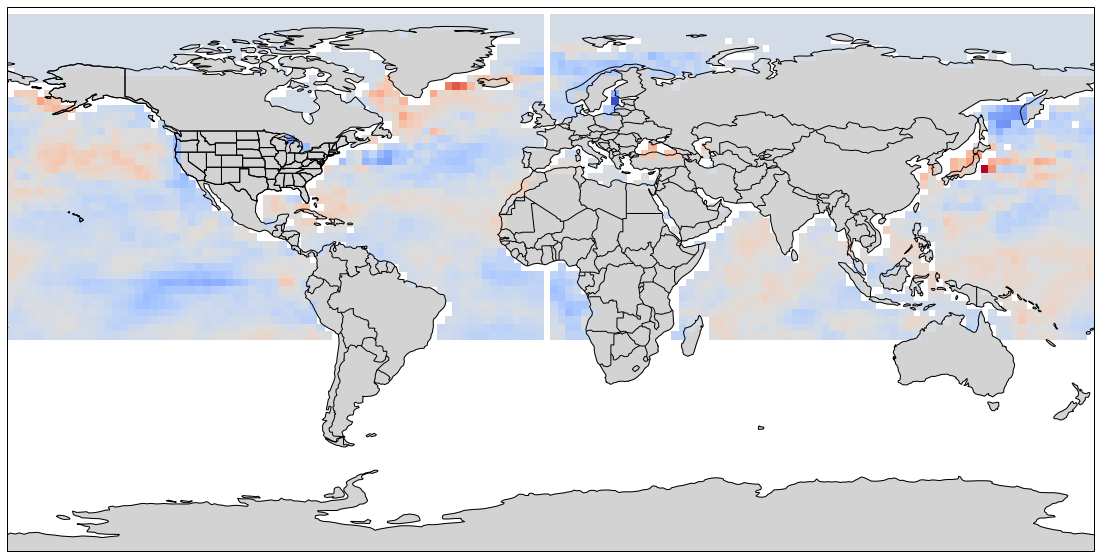

In [199]:
SST = ERA(SST_PATH, 'sst', **ERA5_KWARGS)
SST = ERA(SST_PATH, 'sst', **ERA5_KWARGS, index=[summer_indices(T2M.time, EXTEND_SUMMER)])

# Plot Clusters
projection = utils.plot_earth()
plt.pcolormesh(SST.longitude, SST.latitude, SST.data[0], cmap='coolwarm')
plt.show()

In [205]:
SST_ANOMALY = []

for train_indices, test_indices in INDICES:
    SST_TRAIN = SST.data[train_indices].reshape(len(train_indices)//60, 60, len(SST.latitude), len(SST.longitude))
    SST_TEST = SST.data[test_indices].reshape(len(test_indices)//60, 60, len(SST.latitude), len(SST.longitude))
    
    SST_MEAN_TRAIN = SST_TRAIN.mean(0, keepdims=True)
    SST_STD_TRAIN = SST_TRAIN.std(0, keepdims=True)
    
    SST_ANOMALY_TRAIN = (SST_TRAIN - SST_MEAN_TRAIN) / SST_STD_TRAIN
    SST_ANOMALY_TEST = (SST_TEST - SST_MEAN_TRAIN) / SST_STD_TRAIN
    
    SST_ANOMALY.append((
        SST_ANOMALY_TRAIN.reshape(-1, len(SST.latitude), len(SST.longitude)),
        SST_ANOMALY_TEST.reshape(-1, len(SST.latitude), len(SST.longitude))
    ))

In [211]:
for (X_train, X_test), (y_train, y_test) in zip(SST_ANOMALY, T95):
    print((X_train.shape, y_train.shape), (X_test.shape, y_test.shape))

((1800, 44, 144), (1800, 1)) ((600, 44, 144), (600, 1))
((1800, 44, 144), (1800, 1)) ((600, 44, 144), (600, 1))
((1800, 44, 144), (1800, 1)) ((600, 44, 144), (600, 1))
((1800, 44, 144), (1800, 1)) ((600, 44, 144), (600, 1))
